In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from fastsim import simdrive, vehicle, cycle

In [387]:
class Vehicle():
    def __init__(self):
        self.battery_kwh = 54e3 #Wh
        self.nom_volt = 900 #volts
        self.mass = 1200 #kgs
        self.rho = 1.22
        self.velocity = 55 #mph
        self.A = 2.46 #m^2
        self.cd = 0.75

    def Power_electronics(self):
        eneg = self.battery_kwh
        ecu = 5000 #Wh
        brake_light = 50 #Wh
        radio = 50 #Wh
        eneg = eneg - (ecu + brake_light + radio)
        print(eneg)
        return eneg
    
    # def motor_efficiency(self):

    def battery(self):
        eneg = self.Power_electronics()
        energy_dens = self.battery_kwh 
        soc_max = 100 
        soc_min = 20 
        battery_eng_cap = energy_dens * self.mass
        battery_eng_cap1 = eneg * self.mass
        battery_col_cap = battery_eng_cap / self.nom_volt
        battery_col_cap1 = battery_eng_cap1 / self.nom_volt
        # print(battery_col_cap)
        t_dis = ((soc_max-soc_min)/100)*(battery_col_cap / 100)
        t_dis1 = ((soc_max-soc_min)/100)*(battery_col_cap1 / 100)
        x = np.linspace(0,100,5)
        y = ((soc_max-x)/100) * (264.5/80)
        v = np.linspace(0,200,10)
        d = v * t_dis
        d1 = v * t_dis1
        fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,10))
        ax1.plot(x,y, '--', color='red')
        ax1.grid(True)
        ax1.set(title='Minimum SOC vs Discharge Time', xlabel= 'Minimum SOC\n(%)', ylabel= 'Discharge time\n(seconds)')
        ax2.plot(v,d, '--', color = 'g')
        ax2.plot(v,d1, '--', color='y')
        ax2.grid(True)
        ax2.set(title='Velocity vs Distance traveled', xlabel= 'Velocity\n(kmph)', ylabel= 'Distance\n(km)')
        plt.show()
    
    def motor(self):
        I = np.linspace(0,30,10)
        Pm = 3*((1-0.5)/0.5)*((I)**2)*0.9
        fig1,ax = plt.subplots(figsize=(10,8))
        ax.plot(I,Pm, '-', color='darkblue')
        ax.grid(True)
        ax.set(title='Rotor Current vs Mechanical Power', xlabel= 'Rotor Current\n(Amps)', ylabel= 'Mechanical Power\n')
        plt.show()
        return Pm 

    def fastsim(self):
        veh = fst.vehicle.Vehicle(18)
        print(veh.Scenario_name)
        cyc = fst.cycle.Cycle("hwfet")
        sim = fst.simdrive.SimDriveClassic(cyc,veh)
        sim.sim_drive()
        print("MPGGE:", sim.mpgge_elec)
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.plot(cyc.cycSecs, sim.soc, label='%')
        ax.set_xlabel('Cycle Time [s]', weight='bold')
        ax.set_ylabel('State of Charge [%]', weight='bold', color='xkcd:bluish')
        ax.tick_params('y', colors='xkcd:bluish')
        ax.set_title('State of Charge vs Time for HWFET')
        plt.show()

    def Suspension(self):
        acceleration = 20
        F_rr = 0.4
        F_drag = 0.5 * self.rho * self.velocity**2 * self.A * self.cd
        F_x = self.mass * acceleration + F_drag + F_rr
        return F_x 
    
    def Wheels(self):
        f_x = self.Suspension()
        t_r  = 12
        wheel_torque = f_x * t_r 
        wheel_angular_speed = self.velocity/t_r 
        # print(wheel_torque) 
        # print(wheel_angular_speed)
        return wheel_angular_speed, wheel_torque

    def Transmission(self):
        wheel_ang_speed, wheel_tq = self.Wheels()
        primary_gear = 3.583
        secondary_gear = 2.166
        third_gear = 1.333
        fourth_gear = 0.9 

        if self.velocity < 40: 
            gear_ratio = primary_gear
        elif  40 <= self.velocity < 80:
            gear_ratio = secondary_gear
        elif 80 <= self.velocity < 130:
            gear_ratio = third_gear
        elif 130 <= self.velocity <= 170:
            gear_ratio = fourth_gear

        motor_torque = wheel_tq / gear_ratio
        motor_speed = wheel_ang_speed * gear_ratio
        motor_output_power = motor_torque * motor_speed
        print(motor_output_power)


48900.0


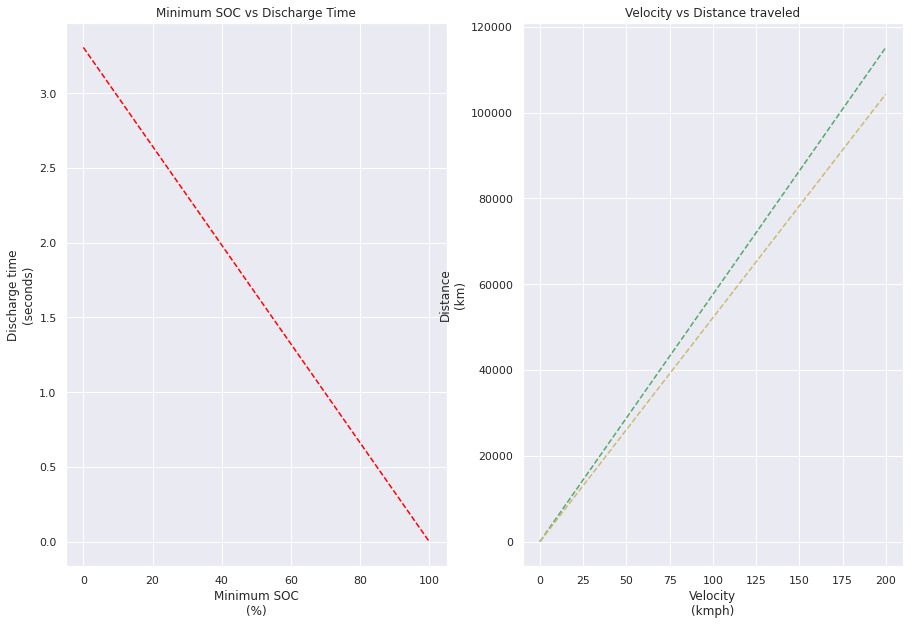

In [388]:
veh1 = Vehicle()
veh1.battery()

# FASTSIM vs REAL LIFE

In [14]:
csv_file = '/home/parth/Downloads/fastsim-2021a/fastsim/resources/cycles/udds.csv'
df = pd.read_csv(csv_file)

vel = df['cycMps']
time= df['cycSecs']

acc = np.diff(vel)/np.diff(time)

In [317]:
m = 903 # kg
g = 9.81 # gravity
ro = 1.22 # air density
Cd = 0.75 # drag coefficient
Crr = 0.012 # rolling resistance
A = 2.46 # vehicle front area 0.0382
Voc = 800 # open circuit voltage
Qbatt = 120e3 # kWh
Rint = 4.0 # 0.796 ohms
Rwheel = 18/(2*39.37) # 35 inch tire diameter
Fgr = 3.2/1 # front gear ratio

motor_efficiency = 0.95
acdc_efficiency = 0.95
trans_efficiency = 0.98
gen_efficiency = 0.4

In [364]:
SOC = 0.98 # initial SOC
Vb = 800 # initial voltage
I = 67.5 # initial current
soc, w, Tm, t, current, voltage = [], [], [], [], [], []
soc1 = []

for i in range(len(acc)):
    Fprop = 0.5*Cd*A*ro*vel[i]**2 + Crr*m*g + m*acc[i]
    Pbatt = Fprop*vel[i]*motor_efficiency*acdc_efficiency*trans_efficiency
    
    if Pbatt > 0:
        if Voc**2 - 4*Pbatt*Rint >= 0:
            Ibatt = ( Voc - np.sqrt( Voc**2 - 4*Pbatt*Rint ) )/(2*Rint)
            
            W = Fgr*(vel[i]/Rwheel)
            T = Pbatt/W
            I -= Ibatt * 0.1
            Vb -= Pbatt/Ibatt * 0.1
            
            w.append(W)
            Tm.append(T)
            soc.append(SOC)
            t.append(time[i])
            current.append( Ibatt )
            voltage.append( Pbatt/Ibatt )
            SOC = SOC - Ibatt/Qbatt * (time[i+1] - time[i])
            
    else:
        soc.append(SOC)
        t.append(time[i])
        Pgen = 2*gen_efficiency*trans_efficiency*( m*acc[i]*vel[i] - Pbatt )
        Igen = 2*(Voc - np.sqrt( Voc**2 - 4*Pgen*Rint ))/(2*Rint)
        SOC = SOC - Igen/Qbatt * (time[i+1] - time[i])

Text(0.5, 1.0, 'SOC vs Time')

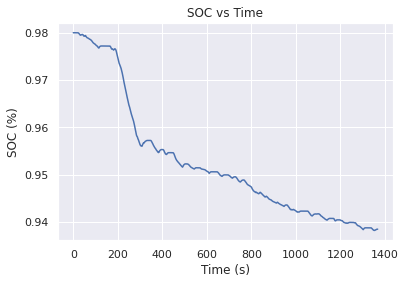

In [365]:
plt.plot(t, soc)
plt.xlabel("Time (s)")
plt.ylabel("SOC (%)")
plt.title("SOC vs Time")

In [361]:
## SOC for power electronics

m = 903 # kg
g = 9.81 # gravity
ro = 1.22 # air density
Cd = 0.75 # drag coefficient
Crr = 0.012 # rolling resistance
A = 2.46 # vehicle front area 0.0382
Voc = 800 # open circuit voltage
Qbatt1 = 115e3 # kWh
Rint = 4.0 # 0.796 ohms
Rwheel = 18/(2*39.37) # 35 inch tire diameter
Fgr = 3.2/1 # front gear ratio

motor_efficiency = 0.95
acdc_efficiency = 0.95
trans_efficiency = 0.98
gen_efficiency = 0.4

In [367]:
SOC1 = 0.98 # initial SOC
Vb = 800 # initial voltage
I1 = 67.5 # initial current
soc1, w1, Tm1, t1, current1, voltage1 = [], [], [], [], [], []

for i in range(len(acc)):
    Fprop1 = 0.5*Cd*A*ro*vel[i]**2 + Crr*m*g + m*acc[i]
    Pbatt1 = Fprop1*vel[i]*motor_efficiency*acdc_efficiency*trans_efficiency
    
    if Pbatt1 > 0:
        if Voc**2 - 4*Pbatt1*Rint >= 0:
            Ibatt1 = ( Voc - np.sqrt( Voc**2 - 4*Pbatt1*Rint ) )/(2*Rint)
            
            W1 = Fgr*(vel[i]/Rwheel)
            T1 = Pbatt1/W1
            I1 -= Ibatt1 * 0.1
            Vb -= Pbatt1/Ibatt1 * 0.1
            
            w1.append(W1)
            Tm1.append(T1)
            soc1.append(SOC1)
            t1.append(time[i])
            current.append( Ibatt1 )
            voltage1.append( Pbatt1/Ibatt1 )
            SOC1 = SOC1 - Ibatt1/Qbatt1 * (time[i+1] - time[i])
            
    else:
        soc1.append(SOC1)
        t1.append(time[i])
        Pgen1 = 2*gen_efficiency*trans_efficiency*( m*acc[i]*vel[i] - Pbatt1 )
        Igen1 = 2*(Voc - np.sqrt( Voc**2 - 4*Pgen1*Rint ))/(2*Rint)
        SOC1 = SOC1 - Igen1/Qbatt1 * (time[i+1] - time[i])

Text(0.5, 1.0, 'SOC vs Time With Power Electronics')

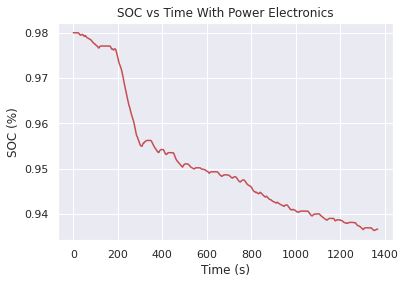

In [389]:
plt.plot(t1, soc1, color='r')
plt.xlabel("Time (s)")
plt.ylabel("SOC (%)")
plt.title("SOC vs Time With Power Electronics")

In [379]:
cyc = cycle.Cycle("udds")
cyc_jit = cyc.get_numba_cyc()
veh = vehicle.Vehicle(18)
veh_jit = veh.get_numba_veh()

In [380]:
veh.vehKg = 1200
veh.maxEssKwh = 45
veh.maxRegenKwh = 250
veh.essKgPerKwh = 0.04
veh.essMassKg = 385
veh.wheelInertiaKgM2 = 0
veh.wheelBaseM = 3.2
veh.maxMotorKw = 280
veh.wheelRadiusM = Rwheel

veh_jit = veh.get_numba_veh()

In [381]:
sim_drive = simdrive.SimDriveJit(cyc_jit, veh_jit)
sim_drive.sim_drive()
sim_drive_post = simdrive.SimDrivePost(sim_drive)
output = sim_drive_post.get_output()
sim_drive_post.set_battery_wear()
diag = sim_drive_post.get_diagnostics()

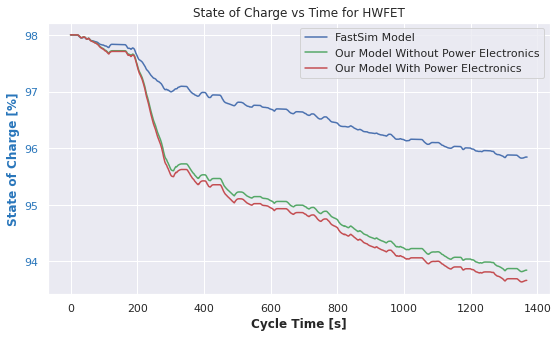

<Figure size 432x288 with 0 Axes>

In [382]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(cyc.cycSecs, output['soc']*100, label='FastSim Model')
ax.plot(t,np.array(soc)*100, color='g', label='Our Model Without Power Electronics')
ax.plot(t,np.array(soc1)*100, color ='r', label='Our Model With Power Electronics')
ax.legend(loc='upper right')
ax.set_xlabel('Cycle Time [s]', weight='bold')
ax.set_ylabel('State of Charge [%]', weight='bold', color='xkcd:bluish')
ax.tick_params('y', colors='xkcd:bluish')
ax.set_title('State of Charge vs Time for HWFET')
plt.show()
plt.subplots_adjust(hspace=0.4)
plt.show()

In [390]:
soc_max = []
err = []
for i in range(1369):
    x = np.maximum(np.array(soc)[:,None][i][0],output['soc'][:-1][:,None][i][0])
    y = np.minimum(np.array(soc)[:,None][i][0],output['soc'][:-1][:,None][i][0])
#     percent_error = ((output['soc'][:-1][:,None][i]*(x-y)))
    percent_error = (np.maximum(np.array(soc)[:,None][i][0],output['soc'][:-1][:,None][i][0]))*(x-y)
    err.append(percent_error)
    soc_max.append(x - y)

In [391]:
np.max(err)*100

1.9236525661195374